In [1]:
import torch
import torch.nn as nn 
import numpy as np
import torchvision
from torchvision.utils import make_grid
from tqdm import tqdm
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1,as_frame=False)

In [4]:
x_train = torch.tensor(mnist.data.reshape(-1,1,28,28))
x_train = (x_train / 255.0)*2 - 1
y_train = torch.tensor(mnist.target.astype(np.int64))

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class Generator(nn.Module):
    def __init__(self,latent_dim,im_size, im_channels,conv_channels,kernels,strides,paddings,out_paddings):
        super().__init__()
        self.latent_dim = latent_dim
        self.im_size = im_size
        self.im_channels = im_channels
        activation = nn.ReLU()
        layers_channel_dim = [self.latent_dim] + conv_channels + [self.im_channels]
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(in_channels=layers_channel_dim[i],out_channels=layers_channel_dim[i+1],
                                   kernel_size = kernels[i],
                                   stride = strides[i],
                                   padding = paddings[i],
                                   output_padding = out_paddings[i],
                                   bias = False 
                                   ),
                nn.BatchNorm2d(layers_channel_dim[i+1]) if i != len(layers_channel_dim) - 2 else nn.Identity(),
                activation if i != len(layers_channel_dim) - 2 else nn.Tanh()     
            )
            for i in range(len(layers_channel_dim)-1)
        ])

    def forward(self, z):
        out = z.reshape(-1,self.latent_dim,1,1)
        for layer in self.layers:
            out = layer(out)
        # out.reshape(-1,self.im_channels,self.im_size,self.im_size)
        return out



In [7]:
class Discriminator(nn.Module):
    def __init__(self, im_size, im_channels, conv_channels, kernels, strides, paddings):
        super().__init__()
        self.im_size = im_size
        self.im_channels = im_channels
        self.conv_channels = [self.im_channels] + conv_channels + [1]
        activation = nn.LeakyReLU()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels=self.conv_channels[i],out_channels=self.conv_channels[i+1],
                kernel_size = kernels[i],
                stride = strides[i],
                padding = paddings[i],
                padding_mode = 'reflect',
                bias = False
                ),
                nn.BatchNorm2d(self.conv_channels[i+1]) if i != len(self.conv_channels) - 2 and i != 0 else nn.Identity(),
                activation if i != len(self.conv_channels) - 2 else nn.Identity()
            ) 
            for i in range(len(self.conv_channels) - 1)
        ])

    def forward(self,gen_out):
        out = gen_out.reshape(-1,self.im_channels,self.im_size,self.im_size)
        for layer in self.layers:
            out = layer(out)
        
        out = out.reshape(-1)
        return out



In [8]:
im_channels = 1
latent_dim = 64
im_size = 28

#for generator
gen_conv_channels = [2048,1024,512]
gen_in_paddings = [0,1,1,0]
gen_out_paddings = [0,1,0,0]
gen_kernels = [3,4,4,2]
gen_strides = [1,2,2,2]

#for discriminator
dis_conv_channels = [1024,512,256]
dis_paddings = [1,1,0,0]
dis_kernels = [4,4,3,3]
dis_strides = [2,2,2,1]



In [9]:
generator = Generator(latent_dim=latent_dim,im_size=im_size,im_channels=1,conv_channels=gen_conv_channels,kernels=gen_kernels,strides=gen_strides,paddings=gen_in_paddings,out_paddings=gen_out_paddings)

In [10]:
discriminator = Discriminator(im_size=im_size,im_channels=im_channels,conv_channels=dis_conv_channels,paddings=dis_paddings,kernels=dis_kernels,strides=dis_strides)

In [16]:
def infer(generated_sample_count,generator):
    fake_im_noise = torch.rand((625,latent_dim),device=device)
    fake_ims = generator(fake_im_noise)
    fake_ims = (fake_ims + 1)/ 2
    fake_ims = fake_ims.detach().cpu()
    grid = make_grid(fake_ims,nrow=25)
    img = torchvision.transforms.ToPILImage()(grid)
    if not os.path.exists('samples'):
        os.makedirs('samples')
    img.save('samples/{}.png'.format(generated_sample_count))

In [17]:
# training function for this dcgan
def train(generator,discriminator,x_train,y_train,mini_batch_size,epochs):
    mnist_data = TensorDataset(x_train,y_train)
    data_loader = DataLoader(mnist_data,batch_size=mini_batch_size,shuffle=True)

    generator.to(device)
    generator.train()

    discriminator.to(device)
    discriminator.train()

    optim_gen = Adam(generator.parameters(),lr=1E-4, betas=(0.5,0.999))
    optim_dis = Adam(discriminator.parameters(),lr=1E-4, betas=(0.5,0.999))

    loss_func = nn.BCEWithLogitsLoss()

    steps = 0
    generated_sample_count = 0

    for i in range(epochs):
        print("Epoch no - ",i+1,"/",epochs)
        for imgs,labels in tqdm(data_loader):
            real_imgs = imgs.float().to(device)
            data_batch_size = real_imgs.shape[0]


            #updating the discriminator params with respect to calculated loss
            optim_dis.zero_grad()
            latent_noise = torch.randn((data_batch_size,latent_dim),device=device)
            fake_imgs = generator(latent_noise)
            real_labels = torch.ones((data_batch_size,1),device=device)
            fake_labels = torch.zeros((data_batch_size,1),device=device)
            real_im_pred = discriminator(real_imgs)
            fake_im_pred = discriminator(fake_imgs.detach()) #to stop gradient updates for generator here
            loss_real_dis = loss_func(real_im_pred.reshape(-1),real_labels.reshape(-1))
            loss_fake_dis = loss_func(fake_im_pred.reshape(-1),fake_labels.reshape(-1))
            total_loss = (loss_real_dis  + loss_fake_dis)/2
            total_loss.backward()
            optim_dis.step()

            #updating the generator params by foolingthe discriminator
            optim_gen.zero_grad()
            latent_noise = torch.randn((data_batch_size,latent_dim),device=device)
            fake_imgs = generator(latent_noise)
            disc_fake_pred = discriminator(fake_imgs)
            loss_gen = loss_func(disc_fake_pred.reshape(-1),real_labels.reshape(-1))
            loss_gen.backward()
            optim_gen.step()


            if (steps % 300) == 0:
                with torch.no_grad():
                    generator.eval() # switch the generator to evaluation mode
                    infer(generated_sample_count,generator)
                    generated_sample_count += 1
                    generator.train() # again switched to training mode
            steps += 1

                
        torch.save(generator.state_dict(),'generator_ckpt.pth')
        torch.save(discriminator.state_dict(),'discriminator_ckpt.pth')

    print('Done Training.....')


In [14]:
generator.load_state_dict(torch.load('generator_ckpt.pth',weights_only=True))
discriminator.load_state_dict(torch.load('discriminator_ckpt.pth',weights_only=True))

<All keys matched successfully>

In [18]:
train(generator=generator,discriminator=discriminator,x_train=x_train,y_train=y_train,mini_batch_size=64,epochs=5)

Epoch no -  1 / 5


100%|██████████| 1094/1094 [05:25<00:00,  3.37it/s]


Epoch no -  2 / 5


100%|██████████| 1094/1094 [06:00<00:00,  3.03it/s]


Epoch no -  3 / 5


100%|██████████| 1094/1094 [06:16<00:00,  2.91it/s]


Epoch no -  4 / 5


100%|██████████| 1094/1094 [06:21<00:00,  2.86it/s]


Epoch no -  5 / 5


100%|██████████| 1094/1094 [06:09<00:00,  2.96it/s]


Done Training.....


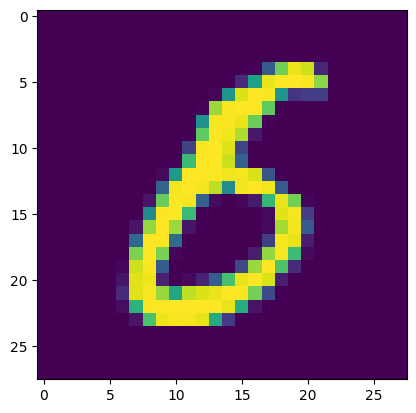

In [56]:
import matplotlib.pyplot as plt
in_x = torch.randn((1,64),device=device)
op = generator(in_x) 
op2 = (op+1)/2
op2 = op2.detach().cpu()
plt.imshow(op2[0].permute(1, 2, 0))


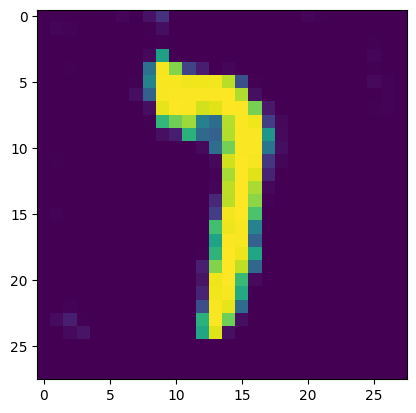